In [3]:
#### Importing Libraries ####

import pandas as pd
from dateutil import parser
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

dataset = pd.read_csv('/Users/swagataashwani/Desktop/MachineLearningTemplate/app_behavior/P39-CS3-Data/appdata10.csv')

In [4]:
#### EDA ####


dataset.head(10) # Viewing the Data
dataset.describe() # Distribution of Numerical Variables

# First set of Feature cleaning
dataset["hour"] = dataset.hour.str.slice(1, 3).astype(int)

In [5]:
### Plotting
dataset2 = dataset.copy().drop(columns = ['user', 'screen_list', 'enrolled_date',
                                           'first_open', 'enrolled'])
dataset2.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked
0,3,2,23,15,0,0,0
1,6,1,24,13,0,0,0
2,1,19,23,3,0,1,1
3,4,16,28,40,0,0,0
4,1,18,31,32,0,0,1


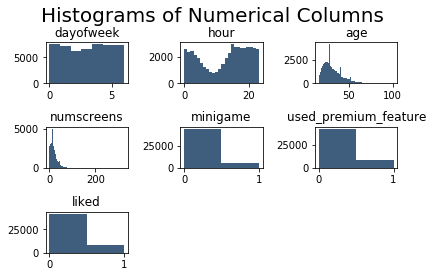

In [6]:
## Histograms
plt.suptitle('Histograms of Numerical Columns', fontsize=20)
for i in range(1, dataset2.shape[1] + 1):
    plt.subplot(3, 3, i)
    f = plt.gca()
#    f.axes.get_yaxis().set_visible(False)
    f.set_title(dataset2.columns.values[i - 1])

    vals = np.size(dataset2.iloc[:, i - 1].unique())
    
    plt.hist(dataset2.iloc[:, i - 1], bins=vals, color='#3F5D7D')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.savefig('app_data_hist.jpg')

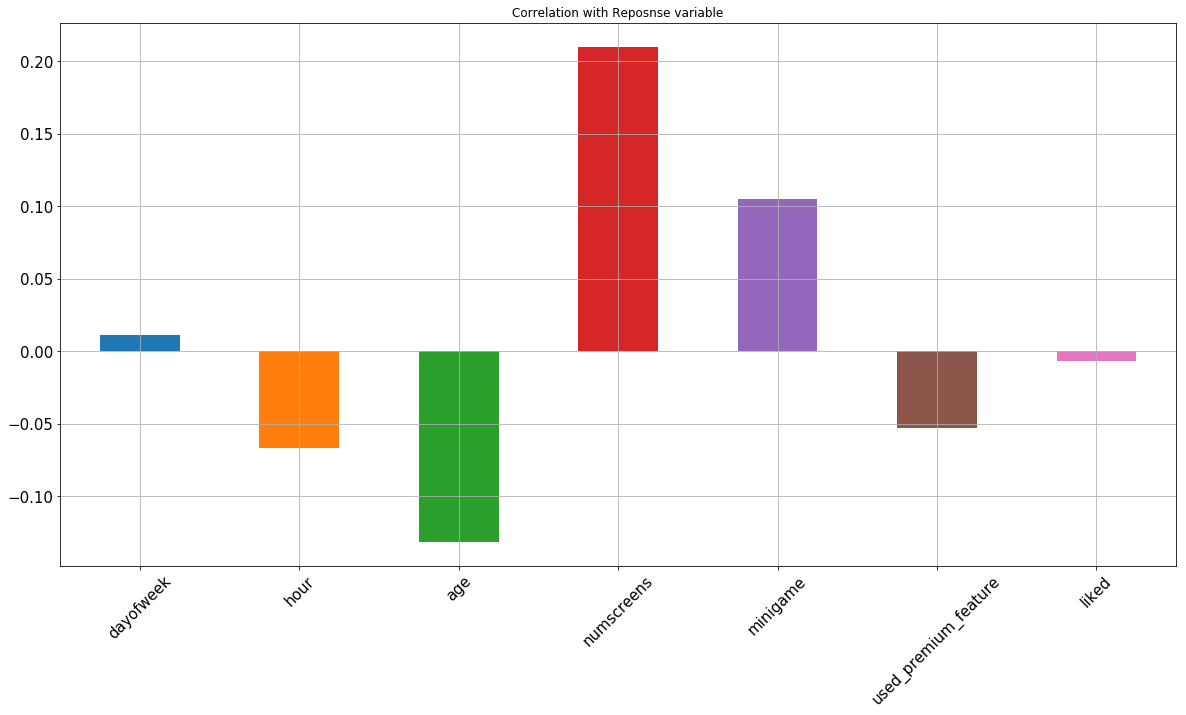

In [7]:
## Correlation with Response Variable
dataset2.corrwith(dataset.enrolled).plot.bar(figsize=(20,10),
                  title = 'Correlation with Reposnse variable',
                  fontsize = 15, rot = 45,
                  grid = True)

In [8]:
## Correlation Matrix
sn.set(style="white", font_scale=2)

# Compute the correlation matrix
corr = dataset2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

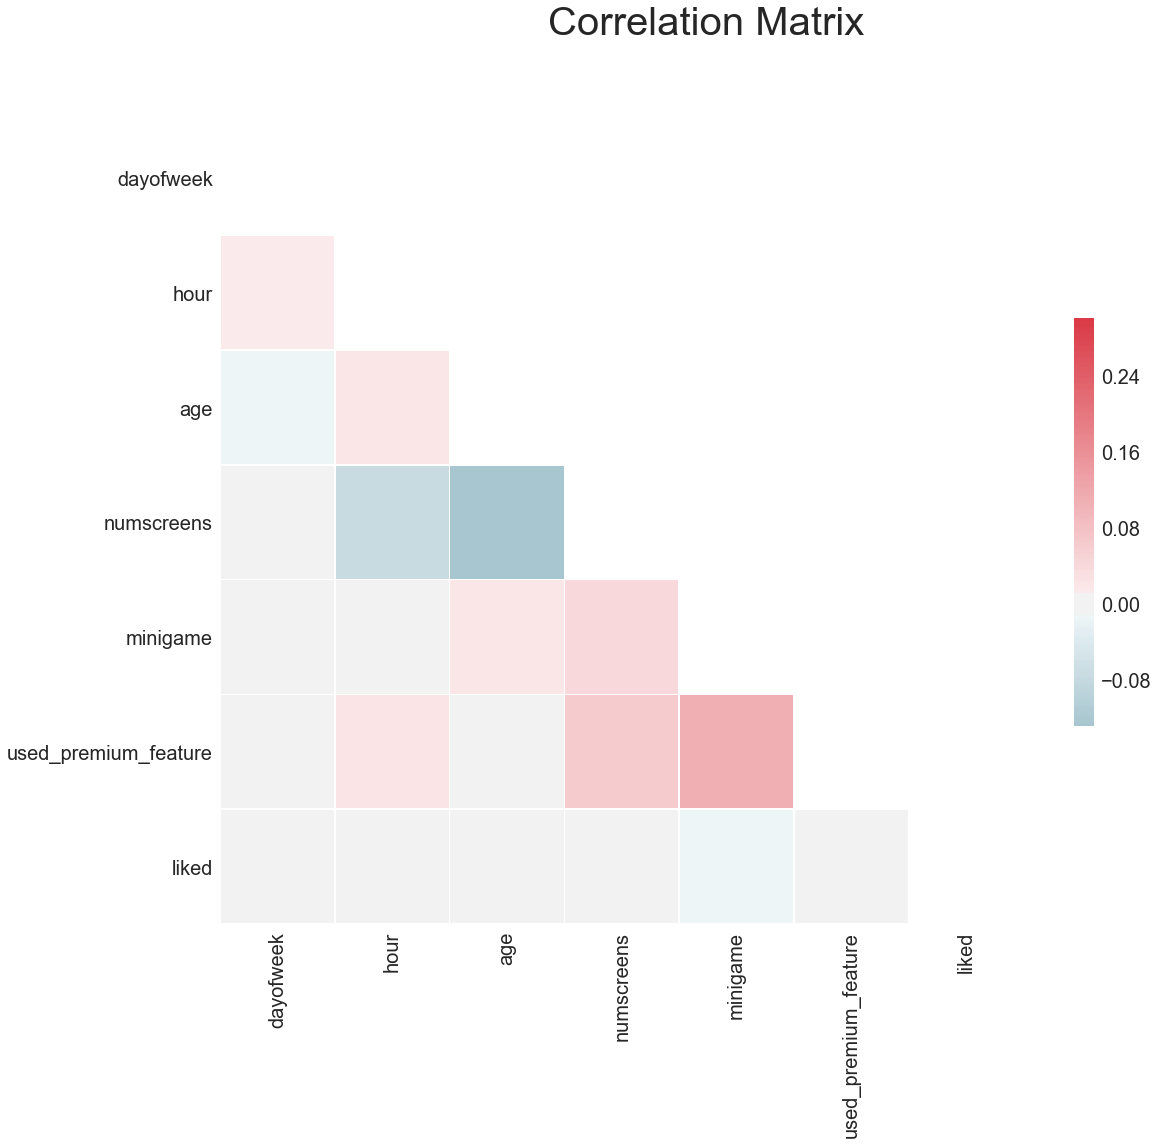

In [9]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))
f.suptitle("Correlation Matrix", fontsize = 40)

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [10]:
#### Feature Engineering ####


# Formatting Date Columns
dataset.dtypes
dataset["first_open"] = [parser.parse(row_date) for row_date in dataset["first_open"]]
dataset["enrolled_date"] = [parser.parse(row_date) if isinstance(row_date, str) else row_date for row_date in dataset["enrolled_date"]]
dataset.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                             int64
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
dtype: object

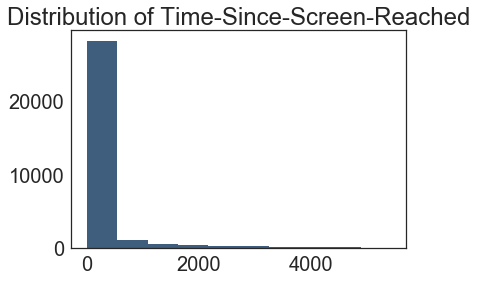

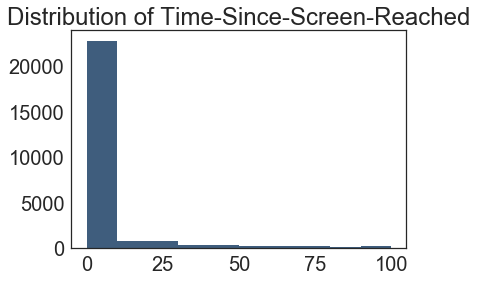

In [11]:
# Selecting Time For Response
dataset["difference"] = (dataset.enrolled_date-dataset.first_open).astype('timedelta64[h]')
response_hist = plt.hist(dataset["difference"].dropna(), color='#3F5D7D')
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

plt.hist(dataset["difference"].dropna(), color='#3F5D7D', range = [0, 100])
plt.title('Distribution of Time-Since-Screen-Reached')
plt.show()

dataset.loc[dataset.difference > 48, 'enrolled'] = 0
dataset = dataset.drop(columns=['enrolled_date', 'difference', 'first_open'])

In [13]:
## Formatting the screen_list Field

# Load Top Screens
top_screens = pd.read_csv('/Users/swagataashwani/Desktop/MachineLearningTemplate/app_behavior/P39-CS3-Data/top_screens.csv').top_screens.values
top_screens

array(['Loan2', 'location', 'Institutions', 'Credit3Container',
       'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen',
       'Credit3Dashboard', 'Loan3', 'CC1Category', 'Splash', 'Loan',
       'CC1', 'RewardsContainer', 'Credit3', 'Credit1', 'EditProfile',
       'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1', 'Alerts',
       'Saving8', 'Saving10', 'Leaderboard', 'Saving4', 'VerifyMobile',
       'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'Loan4',
       'ResendToken', 'TransactionList', 'NetworkFailure', 'ListPicker'],
      dtype=object)

In [14]:
# Mapping Screens to Fields
dataset["screen_list"] = dataset.screen_list.astype(str) + ','

for sc in top_screens:
    dataset[sc] = dataset.screen_list.str.contains(sc).astype(int)
    dataset['screen_list'] = dataset.screen_list.str.replace(sc+",", "")

dataset['Other'] = dataset.screen_list.str.count(",")
dataset = dataset.drop(columns=['screen_list'])



In [15]:
# Funnels
savings_screens = ["Saving1",
                    "Saving2",
                    "Saving2Amount",
                    "Saving4",
                    "Saving5",
                    "Saving6",
                    "Saving7",
                    "Saving8",
                    "Saving9",
                    "Saving10"]
dataset["SavingCount"] = dataset[savings_screens].sum(axis=1)
dataset = dataset.drop(columns=savings_screens)

cm_screens = ["Credit1",
               "Credit2",
               "Credit3",
               "Credit3Container",
               "Credit3Dashboard"]
dataset["CMCount"] = dataset[cm_screens].sum(axis=1)
dataset = dataset.drop(columns=cm_screens)

cc_screens = ["CC1",
                "CC1Category",
                "CC3"]
dataset["CCCount"] = dataset[cc_screens].sum(axis=1)
dataset = dataset.drop(columns=cc_screens)

loan_screens = ["Loan",
               "Loan2",
               "Loan3",
               "Loan4"]
dataset["LoansCount"] = dataset[loan_screens].sum(axis=1)
dataset = dataset.drop(columns=loan_screens)



In [16]:
#### Saving Results ####
dataset.head()
dataset.describe()
dataset.columns

dataset.to_csv('new_appdata10.csv', index = False)